Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.8133 - auc: 0.8794 - loss: 0.4104 - val_accuracy: 0.8282 - val_auc: 0.8960 - val_loss: 0.3837
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.8335 - auc: 0.9010 - loss: 0.3741 - val_accuracy: 0.8321 - val_auc: 0.9001 - val_loss: 0.3753
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.8367 - auc: 0.9045 - loss: 0.3671 - val_accuracy: 0.8332 - val_auc: 0.9028 - val_loss: 0.3709
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.8382 - auc: 0.9064 - loss: 0.3634 - val_accuracy: 0.8340 - val_auc: 0.9043 - val_loss: 0.3687
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.8392 - auc: 0.9074 - loss: 0.3613 - val_accuracy: 0.8367 - val_auc: 0.9050 - val_loss: 0.3661
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.8407 - auc: 0.9085 - loss: 0.3592 - val_accuracy: 0.8372 - val_auc: 0.9058 - val_loss: 0.3647
Epoch 7/20
782/782 ━━━━━━━━━

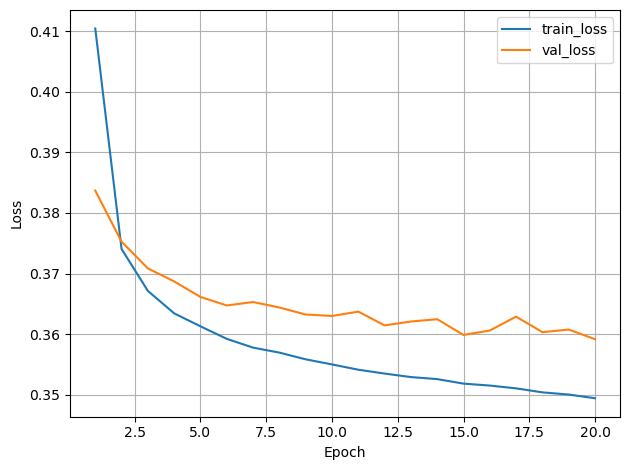

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ===== データ読み込み =====
df = pd.read_csv("training.csv")

# ラベル (s→1, b→0)
y = (df["Label"] == "s").astype(int).values

# 特徴量 (EventId, Weight, Label を除く)
X = df.drop(columns=["EventId", "Weight", "Label"]).values

# ===== 欠損値処理 (-999 を NaN とみなして median で埋める) =====
X = np.where(X == -999.0, np.nan, X)
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# ===== train / validation 分割 =====
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===== スケーリング =====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# ===== DNN モデル定義 =====
input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid"),  # 2値分類 → 出力1, sigmoid
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

model.summary()

# モデルの概要図を出力
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="model_diagram.png",
    show_shapes=True,
    show_layer_names=True
)

from IPython.display import Image
Image(filename="model_diagram.png")

# ===== 学習 =====
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,
    verbose=1,
)

# ===== validation 評価 =====
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"val_acc = {val_acc:.3f}, val_auc = {val_auc:.3f}")

# ===== loss vs epoch (train / val) =====
plt.figure()
epochs = range(1, len(history.history["loss"]) + 1)
plt.plot(epochs, history.history["loss"], label="train_loss")
plt.plot(epochs, history.history["val_loss"], label="val_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_vs_epoch.png", dpi=150)
# plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


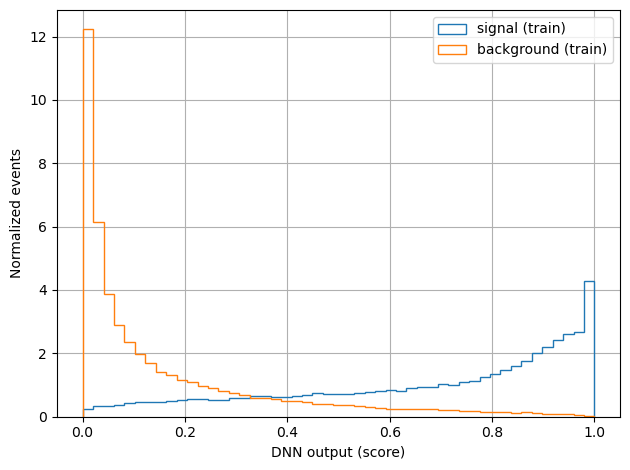

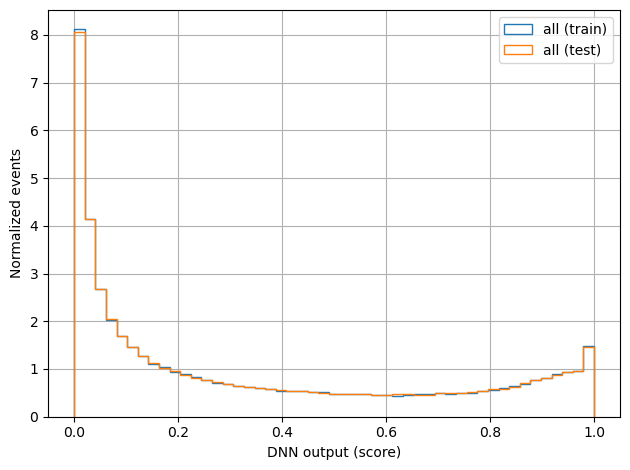

In [ ]:

# ===== BG / signal の classification score 分布 =====
# train / test をオーバーレイ

# 予測スコア（0〜1）
scores_train = model.predict(X_train, batch_size=4096).ravel()
scores_test  = model.predict(X_test,  batch_size=4096).ravel()

bins = np.linspace(0.0, 1.0, 50)

# --- (1) train 側の BG / signal 分布 ---
plt.figure()
plt.hist(
    scores_train[y_train == 1],
    bins=bins,
    histtype="step",
    density=True,
    label="signal (train)",
)
plt.hist(
    scores_train[y_train == 0],
    bins=bins,
    histtype="step",
    density=True,
    label="background (train)",
)
plt.xlabel("DNN output (score)")
plt.ylabel("Normalized events")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("score_dist_train_sig_bg.png", dpi=150)
# plt.show()


#########################
# Overtraining してないか確認

plt.figure()
plt.hist(
    scores_train,
    bins=bins, histtype="step", density=True,
    label="all (train)",
)
plt.hist(
    scores_test,
    bins=bins, histtype="step", density=True,
    label="all (test)",
)
plt.xlabel("DNN output (score)")
plt.ylabel("Normalized events")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("score_dist_train_vs_test_all.png", dpi=150)
# plt.show()